In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from lrgsglib import *
#
cwd = Path.cwd()
while cwd.name != 'lrg_eegfc':
    %cd ..
    cwd = Path.cwd()
#
from src.lrg_eegfc.core import *
#
data_path = Path('data')
fig_path = data_path / Path('figures')
mat_path = Path('data') / 'stereoeeg_patients'
patients_list = [p.name for p in Path(mat_path).iterdir() 
                 if p.is_dir() and p.name.startswith('Pat_')]
#
phase_labels = ['rsPre', 'taskLearn', 'taskTest', 'rsPost']
param_keys_list = ['fs', 'fcutHigh', 'fcutLow', 'filter_order', 'NotchFilter', 'DataDimensions']

/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc


## Data reader

In [2]:
data_dict, int_label_pos_map = load_data_dict(
    mat_path, patients_list, phase_labels, param_keys_list
)

### One Patient, one phase

In [3]:
patient = 'Pat_02'
phase = 'taskLearn'
#
corr_net_filt = dict(threshold=0)
#
data_pat_phase = data_dict[patient][phase]
data_pat_phase_ts = data_pat_phase['data']
fs = data_pat_phase['fs']
filter_order = data_pat_phase['filter_order']
#
n_intervals = 50
interval_length = int(data_pat_phase_ts.shape[1] // n_intervals)
n_intervals, interval_length

(50, 32047)

In [4]:
corr_mat_band_tw = {}
for band_name, (low, high) in tqdm(BRAIN_BANDS.items()):
    corr_mat_band_tw[band_name] = {}
    for i in range(n_intervals):
        start = i * interval_length
        end = (i + 1) * interval_length
        interval_data = data_pat_phase_ts[:, start:end]
        # pay attention the filter is not chnaging if it fails (filter order?)
        filter_data = bandpass_sos(interval_data, low, high, fs, 1)
        corr_mat = build_corr_network(filter_data, threshold=0)
        
        # Find EXACT detachment threshold
        Th, jumps = find_threshold_jumps(nx.from_numpy_array(corr_mat))
        
        corr_mat = build_corr_network(filter_data, threshold=Th[jumps[0]])
        corr_mat_band_tw[band_name][i] = corr_mat

  0%|          | 0/6 [00:00<?, ?it/s]/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0034 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
 17%|█▋        | 1/6 [00:12<01:03, 12.75s/it]/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0039 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
 33%|███▎      | 2/6 [00:26<00:53, 13.32s/it]/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/basic/signals.py:58: RuntimeWarning: Very narrow filter bandwidth (0.0049 of Nyquist). Consider reducing filter order or increasing bandwidth.
  warnings.warn(
100%|██████████| 6/6 [01:25<00:00, 14.32s/it]


Given the LRG induced ultrametric distances 
$$
    \mathcal{D}_{ij}(\tau) = \frac{1 - \delta_{ij}}{K_{ij}(\tau)},
$$
between the nodes in the network built in a time window, one can measure the (Euclidean) distance of distances
$$
    d(\mathcal{D}_{ij}^{t_1}(\tau), \mathcal{D}_{ij}^{t_2}(\tau))
$$
Maybe we want to consider the integral of this quantity ($\int d(\tau)\mathop{\rm d\tau}$) and maybe weight it on the relevant scales of the system.

/home/opisthofulax/anaconda3/envs/lapbrain/lib/python3.12/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:603: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/home/opisthofulax/anaconda3/envs/lapbrain/lib/python3.12/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:150: RuntimeWarning: divide by zero encountered in log
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)
/home/opisthofulax/Documents/research+/brain_network/lrg_eegfc/lrgsglib/src/lrgsglib/utils/lrg/infocomm.py:150: RuntimeWarning: invalid value encountered in multiply
  S[i] = -np.nansum(rho * np.log(rho)) / np.log(N)


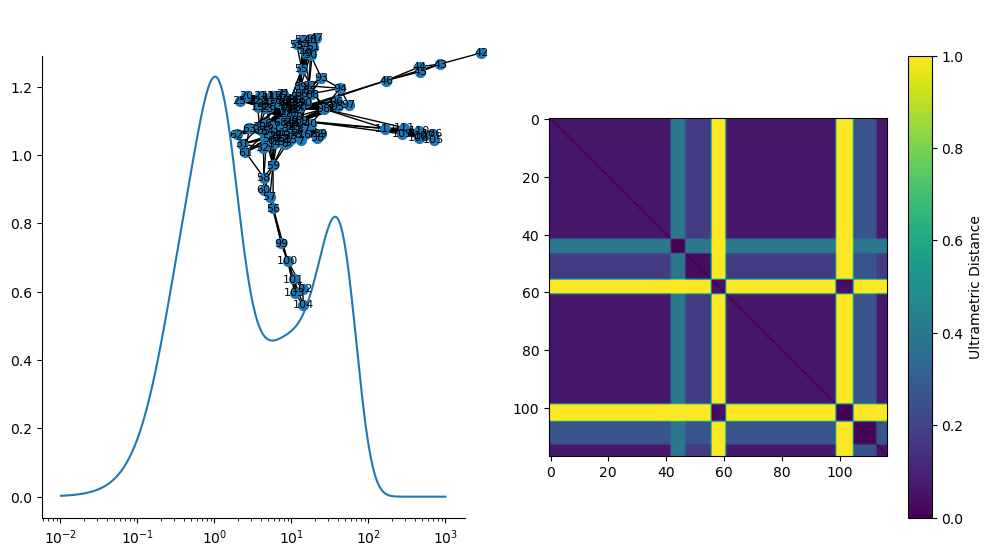

In [5]:
# Example usage with your linkage matrix:
cc = corr_mat_band_tw['low_gamma'][49]
gg = nx.from_numpy_array(cc)
n_nodes = gg.number_of_nodes()
linkage_matrix = MakeLinkageMatrix(gg, tau=10)
ud = extract_ultrametric_matrix(linkage_matrix, n_nodes)
sm1,dS,vL,ttts = entropy(gg, t2=3)
# Visualize the ultrametric distance matrix
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(ttts[1:], dS, '-', label='Entropy')
ax[0].set_xscale('log')
inset_ax = ax[0].inset_axes([0.4, 0.4, 0.7, 0.7])  # [x, y, width, height]
ax[0].spines['top'].set_visible(False)
ax[0].spines['right'].set_visible(False)
pos = nx.nx_agraph.graphviz_layout(gg)
nx.draw(gg, ax=inset_ax, with_labels=True, node_size=50, font_size=8)
im = ax[1].imshow(ud, cmap='viridis')
fig.colorbar(im, ax=ax[1], label='Ultrametric Distance')
plt.show()

In [6]:
ultrametric_distances = []
for i in range(n_intervals):
    cc = corr_mat_band_tw['delta'][i]
    gg = nx.from_numpy_array(cc)
    n_nodes = gg.number_of_nodes()
    linkage_matrix = MakeLinkageMatrix(gg, tau=3)
    ultrametric_distances.append(extract_ultrametric_matrix(linkage_matrix, n_nodes))

In [7]:
# Example: compute pairwise distances between all ultrametric matrices
n = len(ultrametric_distances)
distance_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(i+1, n):
        d = ultrametric_matrix_distance(ultrametric_distances[i], ultrametric_distances[j])
        distance_matrix[i, j] = d
        distance_matrix[j, i] = d
distance_matrix /= np.max(distance_matrix)
# plt.imshow(distance_matrix)
# plt.colorbar()
for i in range(10):
    plt.plot(distance_matrix[i], 'o:', label=f'interval {i}')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

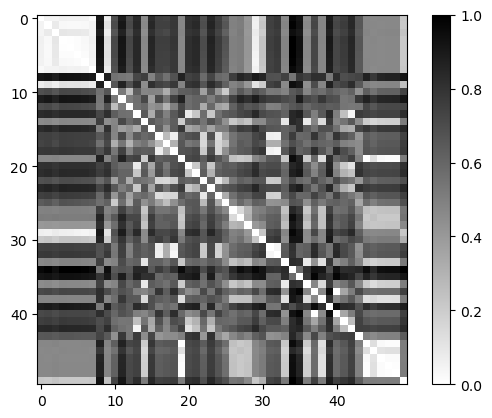

In [ ]:
plt.imshow(distance_matrix, interpolation='none', cmap='binary')
plt.colorbar()

In [ ]:
i1 = 0
i2 = 12

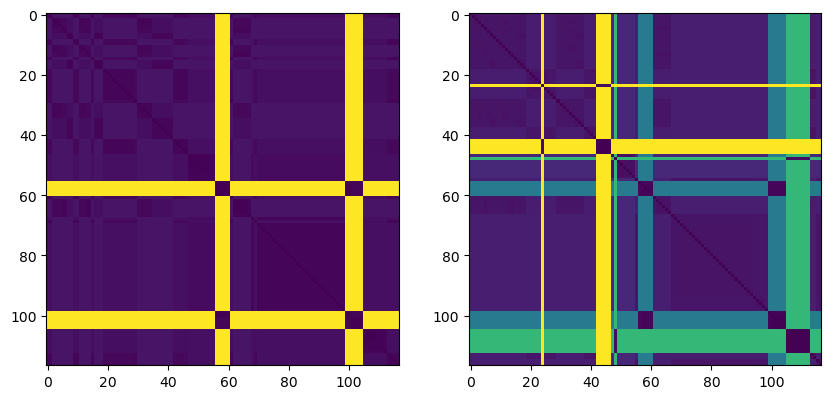

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(ultrametric_distances[i1])
ax[1].imshow(ultrametric_distances[i2])

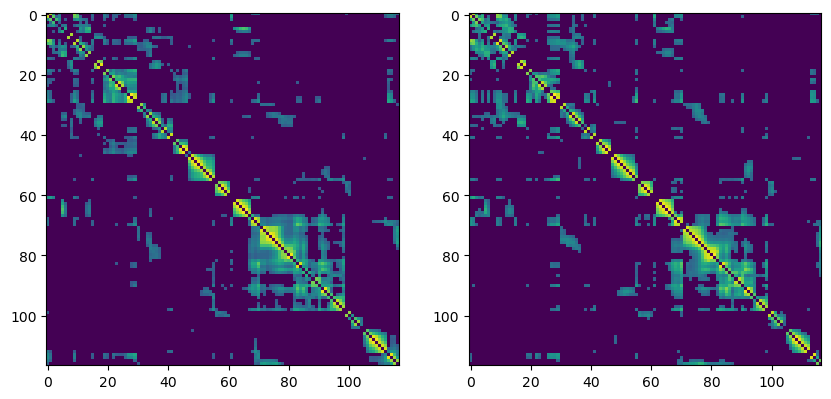

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(corr_mat_band_tw['delta'][i1])
ax[1].imshow(corr_mat_band_tw['delta'][i2])

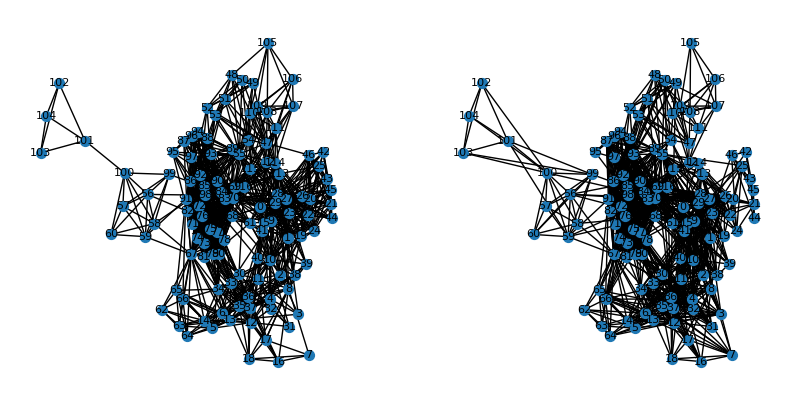

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

cc0 = corr_mat_band_tw['delta'][i1]
cc1 = corr_mat_band_tw['delta'][i2]
gg0 = nx.from_numpy_array(cc0)
gg1 = nx.from_numpy_array(cc1)

pos0 = nx.nx_agraph.graphviz_layout(gg0)
pos1 = nx.nx_agraph.graphviz_layout(gg1)

nx.draw(gg0, pos=pos0, ax=ax[0], with_labels=True, node_size=50, font_size=8)
nx.draw(gg1, pos=pos0, ax=ax[1], with_labels=True, node_size=50, font_size=8)